===== Red centralizada (estrella) =====
Nodos: 30
Aristas: 29
Grado máximo: 29
Grado promedio: 1.933
Longitud media de camino: 1.933
Clustering promedio: 0.000

===== Red distribuida (Erdős–Rényi) =====
Nodos: 30
Aristas: 143
Grado máximo: 14
Grado promedio: 9.533
Longitud media de camino: 1.678
Clustering promedio: 0.326



/tmp/ipython-input-1177054288.py:172: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


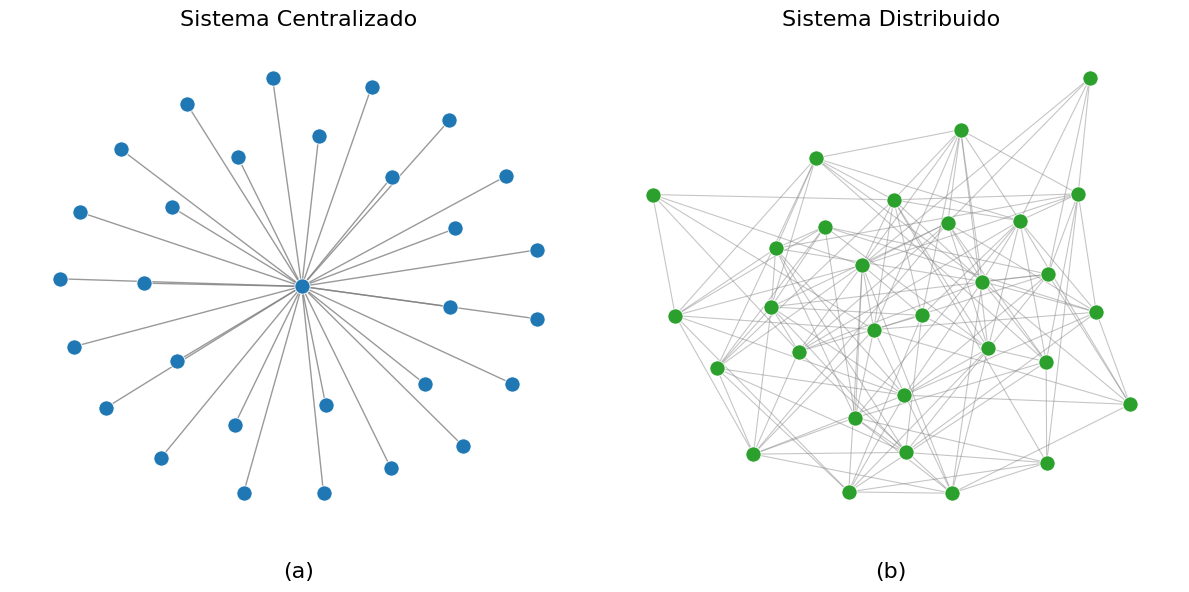

In [1]:
#!/usr/bin/env python3
"""
Script: centralizada_vs_distribuida.py

Visualiza y compara dos topologías de red sin depender de SciPy:
  1) Red centralizada (estrella / hub-and-spoke)
  2) Red distribuida (malla aleatoria densa)

Incluye mejoras estéticas para reducir solapamientos (layout "multi‑start" con
`spring_layout`, curvatura ligera en aristas, transparencia, y elección
configurable de layout) y un modo de autopruebas.

Uso básico:
  python centralizada_vs_distribuida.py --n 30 --p 0.30 --seed 42

Opciones útiles:
  --layout {spring,circular,shell,spectral,kk}   # "kk" intenta Kamada–Kawai si está SciPy; si no, cae a spring
  --out figura.png                               # guarda la figura además de mostrarla
  --dpi 200                                      # resolución al guardar
  --no-show                                      # no abre ventana; solo calcular métricas/guardar
  --self-test                                    # ejecuta pruebas rápidas y sale

Requisitos:
  - Python 3.9+
  - networkx
  - matplotlib

Instalación rápida:
  pip install networkx matplotlib
"""
from __future__ import annotations

import argparse
from dataclasses import dataclass
import math
import random
from typing import Dict, Tuple, List, Optional

import matplotlib.pyplot as plt
import networkx as nx


# ========================
# Datos y utilidades
# ========================
@dataclass
class GraphStats:
    nodes: int
    edges: int
    max_degree: int
    avg_degree: float
    avg_shortest_path: float | None
    avg_clustering: float


def build_centralized(n: int) -> nx.Graph:
    """Crea un grafo estrella con n nodos (1 hub + n-1 hojas)."""
    if n < 2:
        raise ValueError("n debe ser >= 2 para una red centralizada significativa")
    return nx.star_graph(n - 1)


def build_distributed(n: int, p: float = 0.25, seed: int | None = None) -> nx.Graph:
    """Crea un grafo distribuido denso (Erdős–Rényi G(n,p)) y garantiza conectividad
    quedándose con el componente más grande si fuera necesario."""
    if seed is not None:
        random.seed(seed)
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    if not nx.is_connected(G):
        largest_cc = max(nx.connected_components(G), key=len)
        G = G.subgraph(largest_cc).copy()
    return G


def compute_stats(G: nx.Graph) -> GraphStats:
    degrees = [d for _, d in G.degree()]
    max_degree = max(degrees) if degrees else 0
    avg_degree = sum(degrees) / G.number_of_nodes() if G.number_of_nodes() else 0.0
    try:
        asp = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
    except nx.NetworkXError:
        asp = None
    clustering = nx.average_clustering(G) if G.number_of_nodes() else 0.0
    return GraphStats(
        nodes=G.number_of_nodes(),
        edges=G.number_of_edges(),
        max_degree=max_degree,
        avg_degree=avg_degree,
        avg_shortest_path=asp,
        avg_clustering=clustering,
    )


# ========================
# Layouts "bonitos" sin SciPy
# ========================

def _min_pairwise_distance_squared(pos: Dict[int, Tuple[float, float]]) -> float:
    """Heurística: distancia mínima entre nodos (cuanto mayor, menos solapamiento)."""
    coords = list(pos.values())
    best = float("inf")
    for i in range(len(coords)):
        x1, y1 = coords[i]
        for j in range(i + 1, len(coords)):
            x2, y2 = coords[j]
            d2 = (x1 - x2) ** 2 + (y1 - y2) ** 2
            if d2 < best:
                best = d2
            if best == 0: return 0.0 # optimization
    return best if best != float("inf") else 0.0


def distributed_layout(G: nx.Graph, seed: int | None, layout: str = "spring") -> Dict[int, Tuple[float, float]]:
    """Devuelve posiciones para el grafo distribuido sin requerir SciPy.

    - "kk": intenta usar Kamada–Kawai si SciPy está disponible; si no, cae a spring.
    - "spring": usa varios reinicios (multi‑start) y elige el de mayor separación mínima.
    - "circular", "shell", "spectral": alternativas que no requieren SciPy.
    """
    layout = (layout or "spring").lower()

    if layout == "kk":
        try:
            import scipy as _  # noqa: F401  # solo para verificar disponibilidad
            return nx.kamada_kawai_layout(G)
        except Exception:
            layout = "spring"  # caída segura sin SciPy

    if layout == "circular":
        return nx.circular_layout(G)
    if layout == "shell":
        return nx.shell_layout(G)
    if layout == "spectral":
        return nx.spectral_layout(G)

    # spring (por defecto): multi‑inicio para mejorar separación
    trials = 7
    best_pos = None
    best_score = -1.0
    # Escala de repulsión: k≈1/sqrt(n) funciona bien para densos
    k = 1 / max(2.0, math.sqrt(max(1, G.number_of_nodes())))
    for t in range(trials):
        local_seed = None if seed is None else seed + t
        pos = nx.spring_layout(G, seed=local_seed, k=k, iterations=300)
        score = _min_pairwise_distance_squared(pos)
        if score > best_score:
            best_score = score
            best_pos = pos
    return best_pos or nx.spring_layout(G, seed=seed)


# ========================
# Pintado
# ========================

def draw_graphs(Gc: nx.Graph, Gd: nx.Graph, seed: int | None = None, layout: str = "spring") -> None:
    """Dibuja ambos grafos lado a lado, cuidando el solapamiento de aristas/nodos."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Centralizada (estrella)
    ax = axes[0]
    pos_c = nx.spring_layout(Gc, seed=seed)
    nx.draw_networkx_nodes(Gc, pos_c, ax=ax, node_size=120, node_color="#1f77b4", edgecolors="#ffffff", linewidths=0.6)
    nx.draw_networkx_edges(Gc, pos_c, ax=ax, width=1.0, edge_color="gray", alpha=0.8)
    ax.set_title("Sistema Centralizado", fontsize=16) # Increased fontsize
    ax.text(0.5, -0.05, "(a)", ha='center', va='top', transform=ax.transAxes, fontsize=16) # Added label (a)
    ax.axis("off")

    # Distribuida (bonita, sin SciPy)
    ax = axes[1]
    pos_d = distributed_layout(Gd, seed=seed, layout=layout)
    nx.draw_networkx_edges(
        Gd,
        pos_d,
        ax=ax,
        width=0.8,
        alpha=0.45,
        edge_color="gray",
        connectionstyle="arc3,rad=0.06",  # ligera curvatura para menos solapamientos
    )
    nx.draw_networkx_nodes(Gd, pos_d, ax=ax, node_size=120, node_color="#2ca02c", edgecolors="#ffffff", linewidths=0.6)
    ax.set_title("Sistema Distribuido", fontsize=16) # Increased fontsize
    ax.text(0.5, -0.05, "(b)", ha='center', va='top', transform=ax.transAxes, fontsize=16) # Added label (b)
    ax.axis("off")

    #fig.suptitle("Comparación de topologías")
    fig.tight_layout()
    plt.show()
    fig.savefig("sota_9_redes_centr_dist.pdf")


# ========================
# CLI y tests
# ========================

def parse_args(args: Optional[List[str]] = None) -> argparse.Namespace:
    parser = argparse.ArgumentParser(description="Visualiza y compara una red centralizada y una red distribuida")
    parser.add_argument("--n", type=int, default=30, help="Número de nodos en cada red (>= 2)")
    parser.add_argument("--p", type=float, default=0.30, help="Probabilidad de arista en la red distribuida (0,1)")
    parser.add_argument("--seed", type=int, default=42, help="Semilla para reproducibilidad")
    parser.add_argument("--layout", choices=["spring", "circular", "shell", "spectral", "kk"], default="spring", help="Layout para la red distribuida")
    parser.add_argument("--no-show", action="store_true", help="No mostrar ventana; solo calcular métricas/guardar")
    parser.add_argument("--out", type=str, default=None, help="Ruta para guardar la figura (p.ej., figura.png, figura.pdf)")
    parser.add_argument("--dpi", type=int, default=160, help="DPI al guardar la figura")
    parser.add_argument("--self-test", action="store_true", help="Ejecuta pruebas rápidas y sale")
    return parser.parse_args(args)


def run_tests() -> None:
    print("Ejecutando self-test…")
    # 1) Construcción básica sin SciPy
    Gc = build_centralized(8)
    Gd = build_distributed(25, p=0.35, seed=0)
    for layout in ["spring", "circular", "shell", "spectral", "kk"]:
        pos = distributed_layout(Gd, seed=0, layout=layout)
        assert isinstance(pos, dict) and len(pos) == Gd.number_of_nodes()
    # 2) Métricas no vacías y valores coherentes
    sc = compute_stats(Gc)
    sd = compute_stats(Gd)
    assert sc.nodes >= 2 and sd.nodes >= 2
    assert sc.edges == sc.nodes - 1  # estrella
    assert sd.edges >= sd.nodes - 1  # distribuida al menos conectada
    print("OK: construcción, layouts y métricas.")


def main() -> None:
    args = parse_args([]) # Pass an empty list to parse_args to prevent it from reading sys.argv


    if args.self_test:
        run_tests()
        return

    # Construir grafos
    G_central = build_centralized(args.n)
    G_dist = build_distributed(args.n, p=args.p, seed=args.seed)

    # Métricas
    stats_c = compute_stats(G_central)
    stats_d = compute_stats(G_dist)

    # Imprimir comparación en consola
    print(f"===== Red centralizada (estrella) =====\nNodos: {stats_c.nodes}\nAristas: {stats_c.edges}\nGrado máximo: {stats_c.max_degree}\nGrado promedio: {stats_c.avg_degree:.3f}\nLongitud media de camino: {('no definida (grafo no conexo)' if stats_c.avg_shortest_path is None else f'{stats_c.avg_shortest_path:.3f}')}\nClustering promedio: {stats_c.avg_clustering:.3f}\n")
    print(f"===== Red distribuida (Erdős–Rényi) =====\nNodos: {stats_d.nodes}\nAristas: {stats_d.edges}\nGrado máximo: {stats_d.max_degree}\nGrado promedio: {stats_d.avg_degree:.3f}\nLongitud media de camino: {('no definida (grafo no conexo)' if stats_d.avg_shortest_path is None else f'{stats_d.avg_shortest_path:.3f}')}\nClustering promedio: {stats_d.avg_clustering:.3f}\n")

    # Visualización
    fig = None
    if not args.no_show or args.out:
        fig = plt.figure()
        plt.close(fig)  # solo para asegurarnos de que backend está listo
        draw_graphs(G_central, G_dist, seed=args.seed, layout=args.layout)

    # Guardar si procede
    if args.out:
        # Para guardar, redibujamos en un canvas dedicado para evitar que la ventana interactiva afecte
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        pos_c = nx.spring_layout(G_central, seed=args.seed)
        nx.draw_networkx_nodes(G_central, pos_c, ax=axes[0], node_size=120, node_color="#1f77b4", edgecolors="#ffffff", linewidths=0.6)
        nx.draw_networkx_edges(G_central, pos_c, ax=axes[0], width=1.0, edge_color="gray", alpha=0.8)
        axes[0].set_title("Red Centralizada", fontsize=16); axes[0].axis("off") # Increased fontsize
        axes[0].text(0.5, -0.05, "(a)", ha='center', va='top', transform=axes[0].transAxes, fontsize=14) # Added label (a)


        pos_d = distributed_layout(G_dist, seed=args.seed, layout=args.layout)
        nx.draw_networkx_edges(G_dist, pos_d, ax=axes[1], width=0.8, alpha=0.45, edge_color="gray", connectionstyle="arc3,rad=0.06")
        nx.draw_networkx_nodes(G_dist, pos_d, ax=axes[1], node_size=110, node_color="#2ca02c", edgecolors="#ffffff", linewidths=0.6)
        axes[1].set_title("Red Distribuida", fontsize=16); axes[1].axis("off") # Increased fontsize
        axes[1].text(0.5, -0.05, "(b)", ha='center', va='top', transform=axes[1].transAxes, fontsize=14) # Added label (b)
        fig.suptitle("Comparación de topologías")
        fig.tight_layout()
        fig.savefig(args.out, dpi=args.dpi)
        print(f"Figura guardada en: {args.out} (dpi={args.dpi})")

main()